# Transfer learning with pretrained Keras models
Although Kernel resources were increased recently we still can not train useful CNNs without GPU. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.

In [26]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from glob import glob

In [2]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_categories = len(categories)

In [30]:
sample_per_category = 200
seed = 1987
train_dir = 'train/'
test_dir = 'test/'
sample_submission = pd.read_csv('sample_submission.csv')

In [31]:
sample_submission.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [49]:
for category in categories:
    print("{} {} images".format(category,len(glob(train_dir + category +'/*png'))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [80]:
train = []
for category_id, category in enumerate(categories):
    for file in glob(train_dir + category +'/*png'):
        train.append([file, category_id, category])
train = pd.DataFrame(train, columns=['file','category_id','category'])
print(train.shape)
train.head()

(4750, 3)


,file,category_id,category
0,train/Black-grass\0050f38b3.png,0,Black-grass
1,train/Black-grass\0183fdf68.png,0,Black-grass
2,train/Black-grass\0260cffa8.png,0,Black-grass
3,train/Black-grass\05eedce4d.png,0,Black-grass
4,train/Black-grass\075d004bc.png,0,Black-grass


# Training samples

In [81]:
train = pd.concat([train[train['category'] == c][:sample_per_category] for c in categories])
train = train.sample(frac=1)
train.index = np.arange(len(train))
print(train.shape)
train.head()

(2400, 3)


,file,category_id,category
0,train/Shepherds Purse\8d9512864.png,9,Shepherds Purse
1,train/Black-grass\470608aba.png,0,Black-grass
2,train/Sugar beet\67054ec9d.png,11,Sugar beet
3,train/Cleavers\a51e6f301.png,2,Cleavers
4,train/Common wheat\c9562464a.png,4,Common wheat


In [82]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file),file])
test = pd.DataFrame(test, columns = ['filepath','file'])
print(test.shape)
test.head()

(794, 2)


,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png
2,test/007b3da8b.png,007b3da8b.png
3,test/0086a6340.png,0086a6340.png
4,test/00c47e980.png,00c47e980.png


In [83]:
def read_img(filepath,size):
    img = image.load_img(filepath, target_size = size)
    img = image.img_to_array(img)
    return img

# Example images

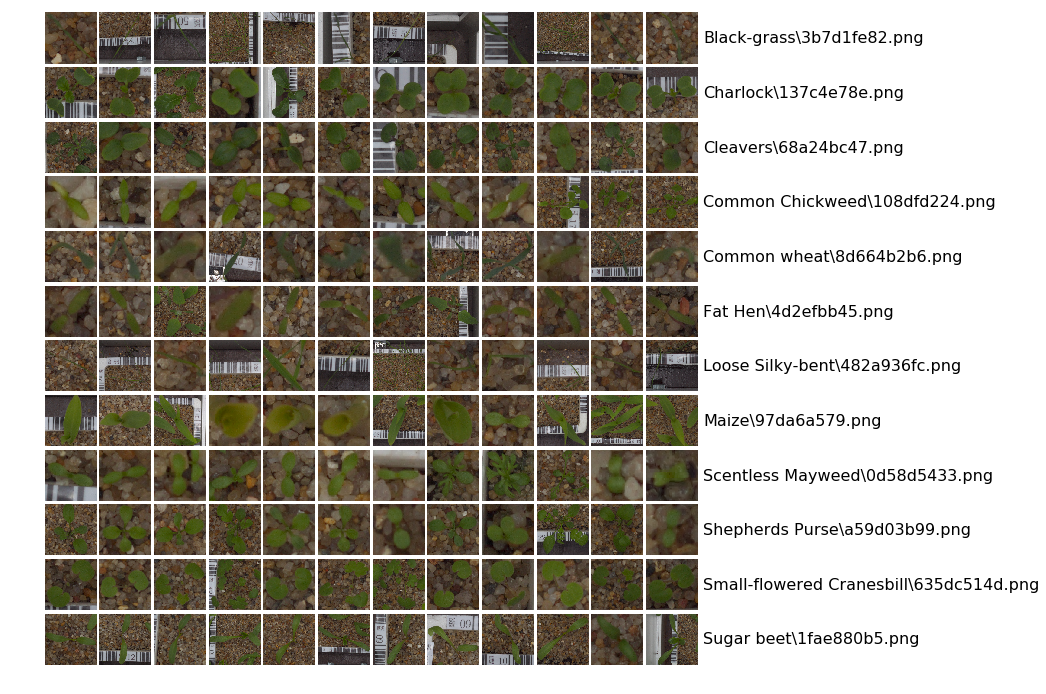

In [84]:
fig = plt.figure(1, figsize=(num_categories, num_categories))
grid = ImageGrid(fig, 111, nrows_ncols=(num_categories, num_categories), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in train[train['category'] == category]['file'].values[:num_categories]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % num_categories == num_categories - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

# Validation Split

In [87]:
np.random.seed(seed=seed)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [94]:
input_size = 299
pooling = 'avg'
x_train = np.zeros((len(train),input_size,input_size,3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (input_size, input_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(),axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [01:22, 29.24it/s]


Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [97]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=pooling)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))
 128/1899 [=>............................] - ETA: 1:45:1 - ETA: 1:39:1 - ETA: 1:38:4 - ETA: 1:38:33

KeyboardInterrupt: 

# LogReg on Xception bottleneck features

In [96]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

NameError: name 'SEED' is not defined

In [ ]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

# Confusion matrix

In [ ]:
cnf_matrix = confusion_matrix(yv, valid_preds)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

# Create submission

In [ ]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

In [ ]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

In [ ]:
test['category_id'] = test_preds
test['species'] = [categories[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)